# Bayesian Polynomial Regression

In [2]:
import numpy as np 
import arviz as az
import matplotlib.pyplot as plt 
import requests
import io 
import csv 
import pandas as pd

In [3]:
target_url = 'https://raw.githubusercontent.com/cfteach/brds/main/datasets/anscombe.csv' 

download = requests.get(target_url).content
ans = pd.read_csv(io.StringIO(download.decode('utf-8')))

x = ans[ans.group == 'II']['x'].values
y = ans[ans.group == 'II']['y'].values
x = x - x.mean()

In [ ]:
f=plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y,'C0.',alpha=0.6, markersize=20)

In [ ]:
#!pip install pymc3

In [4]:
import pymc3 as pm

In [ ]:
with pm.Model() as model_poly:
  alpha = pm.Normal('alpha',mu=y.mean(),sigma=1) 
  beta1 = pm.Normal('beta1',mu=0.,sigma=1) 
  beta2 = pm.Normal('beta2',mu=0.,sigma=1) 
  epsilon = pm.HalfCauchy('epsilon', 5)

  mu = pm.Deterministic('mu',alpha + beta1*x + beta2*x*x)

  y_pred = pm.Normal('y_pred', mu=mu, sigma = epsilon, observed = y)

  trace_poly = pm.sample(2000, tune = 2000, return_inferencedata=True)

In [ ]:
az.plot_trace(trace_poly, var_names = ['alpha','beta1','beta2'])

In [ ]:
res = az.summary(trace_poly)
print(res)

In [ ]:
tr_alpha = res.loc['alpha']
tr_beta1 = res.loc['beta1']
tr_beta2 = res.loc['beta2']

In [ ]:
print(tr_alpha)

In [ ]:
alpha_m = tr_alpha['mean']
beta1_m = tr_beta1['mean']
beta2_m = tr_beta2['mean']

xr = np.linspace(-6,6,100)
yr = alpha_m + beta1_m*xr + beta2_m*xr**2

f = plt.figure(figsize=(10,5))
plt.plot(xr,yr, c='C1')
plt.plot(x,y, 'C0.')

## Perturbed Dataset 

Let's modify the previous dataset by introducing some noise

NameError: name 'xr' is not defined

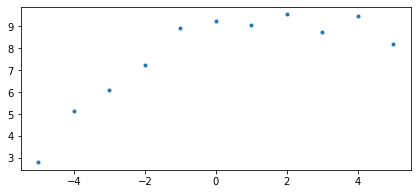

In [6]:

#print(y)
#tidx = int(np.floor(len(y)/2))
#print(tidx)

#print(y[0])
#print(type(y))

yn = y.copy() 
#tidx = 0
#yn[tidx] = yn[tidx] + np.random.normal(0,2.)

yn += np.random.normal(0,.5, len(yn))

f = plt.figure(figsize=(7,3))
plt.plot(x,yn,'C0.')
plt.plot(xr,yr,'--')

In [7]:
with pm.Model() as model_poly2:
  alpha = pm.Normal('alpha',mu=y.mean(),sigma=1) 
  beta1 = pm.Normal('beta1',mu=0.,sigma=1) 
  beta2 = pm.Normal('beta2',mu=0.,sigma=1) 
  epsilon = pm.HalfCauchy('epsilon', 5)

  mu = pm.Deterministic('mu',alpha + beta1*x + beta2*x*x)

  y_pred_per = pm.Normal('y_pred_per', mu=mu, sigma = epsilon, observed = yn)

  trace_poly_per = pm.sample(2000, tune = 2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta2, beta1, alpha]


/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparamete

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>],
       [<AxesSubplot:title={'center':'epsilon'}>,
        <AxesSubplot:title={'center':'epsilon'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

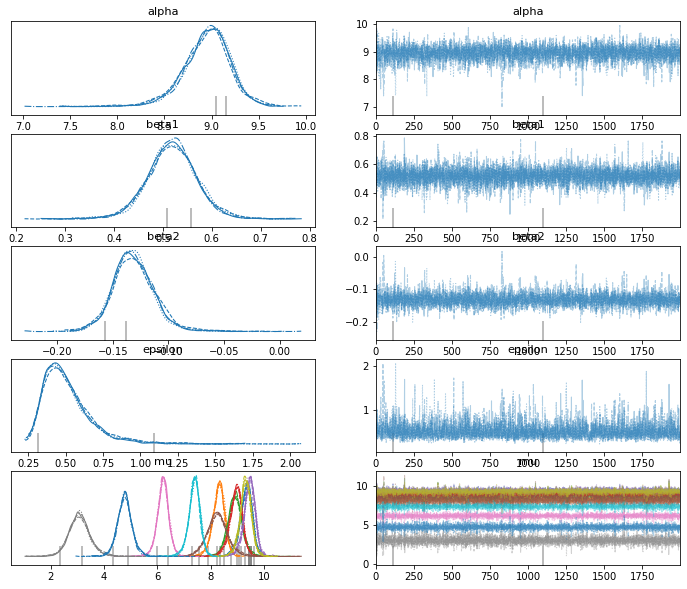

In [8]:
az.plot_trace(trace_poly_per)

In [9]:
res2 = az.summary(trace_poly_per)
print(res2)

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    8.949  0.253   8.461    9.406      0.005    0.003    3571.0   
beta1    0.519  0.052   0.421    0.617      0.001    0.001    4749.0   
beta2   -0.131  0.019  -0.167   -0.096      0.000    0.000    3844.0   
epsilon  0.512  0.172   0.266    0.809      0.003    0.002    2723.0   
mu[0]    9.337  0.245   8.887    9.811      0.004    0.003    3739.0   
mu[1]    8.299  0.245   7.849    8.758      0.004    0.003    3670.0   
mu[2]    8.921  0.288   8.379    9.446      0.004    0.003    5672.0   
mu[3]    8.949  0.253   8.461    9.406      0.005    0.003    3571.0   
mu[4]    9.461  0.227   8.989    9.835      0.004    0.003    4315.0   
mu[5]    8.257  0.417   7.461    9.034      0.006    0.004    4876.0   
mu[6]    6.209  0.228   5.778    6.625      0.003    0.002    5577.0   
mu[7]    3.067  0.419   2.272    3.846      0.006    0.004    5730.0   
mu[8]    9.323  0.228   8.886    9.741      0.003    0.002    55

In [10]:
#az.plot_hdi(x,res2['mu'], color='k')
ppc = pm.sample_posterior_predictive(trace_poly_per, samples=4000, model=model_poly2)


/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<AxesSubplot:>

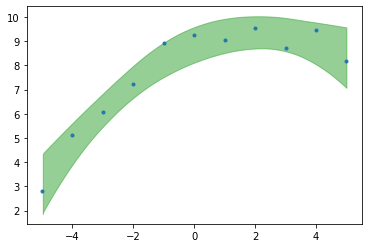

In [11]:
plt.plot(x,yn,'C0.')
az.plot_hdi(x,trace_poly_per.posterior['mu'],color='C2',hdi_prob=.99)

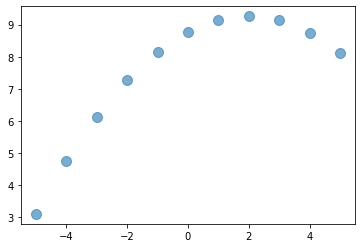

In [12]:
plt.plot(x,y,'C0.',alpha=0.6, markersize=20)

In [13]:
print(x)
print(y)

[ 1. -1.  4.  0.  2.  5. -3. -5.  3. -2. -4.]
[9.14 8.14 8.74 8.77 9.26 8.1  6.13 3.1  9.13 7.26 4.74]


In [53]:
import operator
L = sorted(zip(x,y), key=operator.itemgetter(0))
new_x, new_y = zip(*L)

(-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0)
(3.1, 4.74, 6.13, 7.26, 8.14, 8.77, 9.14, 9.26, 9.13, 8.74, 8.1)


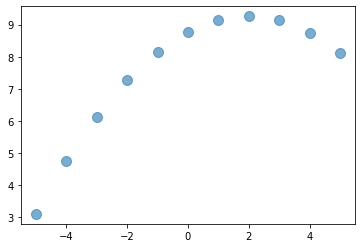

In [54]:
print(new_x)
print(new_y)

plt.plot(new_x,new_y,'C0.',alpha=0.6, markersize=20)

In [55]:
import csv 
header = ['x','y']

#data = []

#for i,j in zip(new_x, new_y):
#    l=[]
#    l.append(i)
#    l.append(j)
#    data.append(l)

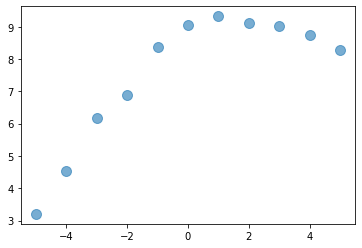

In [56]:
new_y += np.random.normal(0,0.2,len(new_y))

plt.plot(new_x,new_y,'C0.',alpha=0.6, markersize=20)

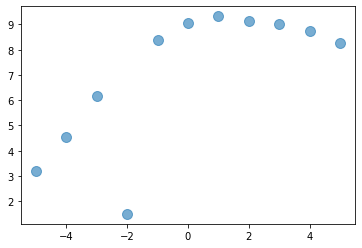

In [57]:
new_y[3]=1.5

plt.plot(new_x,new_y,'C0.',alpha=0.6, markersize=20)

#print(data[3][1])

In [58]:
data = []

for i,j in zip(new_x, new_y):
    l=[]
    l.append(i)
    l.append(j)
    data.append(l)


with open('mod2_part1_a.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(data)

In [59]:
with pm.Model() as model_poly3:
  alpha = pm.Normal('alpha',mu=y.mean(),sigma=1) 
  beta1 = pm.Normal('beta1',mu=0.,sigma=1) 
  beta2 = pm.Normal('beta2',mu=0.,sigma=1) 
  nu = pm.Exponential('nu',1./30.)
  epsilon = pm.HalfCauchy('epsilon', 5)

  mu = pm.Deterministic('mu',alpha + beta1*new_x + beta2*new_x*new_x)

  y_pred_rob = pm.StudentT('y_pred_rob', mu=mu, sigma=epsilon, nu=nu, observed=new_y)
    
  #y_pred_rob = pm.Normal('y_pred_rob', mu=mu, sigma = epsilon, observed = new_y)

  trace_poly_rob = pm.sample(2000, tune = 2000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, nu, beta2, beta1, alpha]


/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.721290807191241

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>],
       [<AxesSubplot:title={'center':'nu'}>,
        <AxesSubplot:title={'center':'nu'}>],
       [<AxesSubplot:title={'center':'epsilon'}>,
        <AxesSubplot:title={'center':'epsilon'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

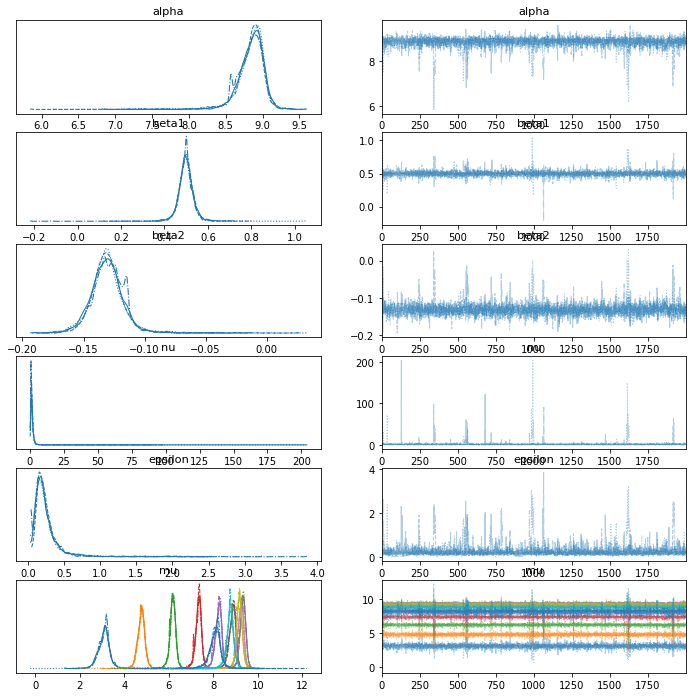

In [60]:
az.plot_trace(trace_poly_rob)

In [61]:
res3 = az.summary(trace_poly_rob)
print(res3)

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    8.834  0.211   8.518    9.145      0.006    0.005    1249.0   
beta1    0.499  0.041   0.435    0.563      0.001    0.001    4199.0   
beta2   -0.130  0.015  -0.156   -0.105      0.000    0.000    1518.0   
nu       1.928  5.441   0.229    3.206      0.138    0.098    1746.0   
epsilon  0.258  0.255   0.030    0.513      0.009    0.006     647.0   
mu[0]    3.085  0.318   2.541    3.592      0.005    0.003    3992.0   
mu[1]    4.755  0.228   4.387    5.106      0.004    0.003    4915.0   
mu[2]    6.165  0.193   5.864    6.456      0.005    0.003    3174.0   
mu[3]    7.315  0.197   7.007    7.599      0.006    0.004    1672.0   
mu[4]    8.204  0.209   7.873    8.501      0.006    0.004    1321.0   
mu[5]    8.834  0.211   8.518    9.145      0.006    0.005    1249.0   
mu[6]    9.203  0.198   8.895    9.489      0.006    0.004    1333.0   
mu[7]    9.312  0.177   9.050    9.588      0.004    0.003    15

<AxesSubplot:>

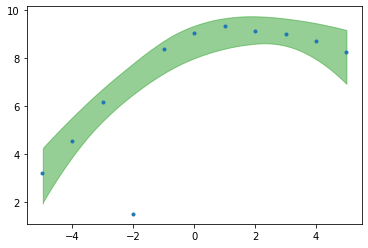

In [62]:
plt.plot(new_x,new_y,'C0.')
az.plot_hdi(new_x,trace_poly_rob.posterior['mu'],color='C2',hdi_prob=.99)

In [63]:
target_url = 'https://raw.githubusercontent.com/cfteach/brds/main/datasets/mod2_part1_a.csv' 

download = requests.get(target_url).content
ans = pd.read_csv(io.StringIO(download.decode('utf-8')))

x = ans['x'].values
y = ans['y'].values

In [64]:
print(x)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


In [65]:
print(y)

[3.20578291 4.54013427 6.1753007  1.5        8.36545909 9.0512373
 9.32320167 9.12941557 9.02906974 8.73327563 8.27209965]


In [69]:
with pm.Model() as model_poly4:
  alpha = pm.Normal('alpha',mu=y.mean(),sigma=1) 
  beta1 = pm.Normal('beta1',mu=0.,sigma=1) 
  beta2 = pm.Normal('beta2',mu=0.,sigma=1) 
  nu = pm.Exponential('nu',1./30.)
  epsilon = pm.HalfCauchy('epsilon', 5)

  mu = pm.Deterministic('mu',alpha + beta1*x + beta2*x*x)

  y_pred_rob = pm.StudentT('y_pred_rob', mu=mu, sigma=epsilon, nu=nu, observed=y)
    
  #y_pred_rob = pm.Normal('y_pred_rob', mu=mu, sigma = epsilon, observed = new_y)

  trace_poly_rob4 = pm.sample(2000, tune = 2000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, nu, beta2, beta1, alpha]


/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>],
       [<AxesSubplot:title={'center':'nu'}>,
        <AxesSubplot:title={'center':'nu'}>],
       [<AxesSubplot:title={'center':'epsilon'}>,
        <AxesSubplot:title={'center':'epsilon'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

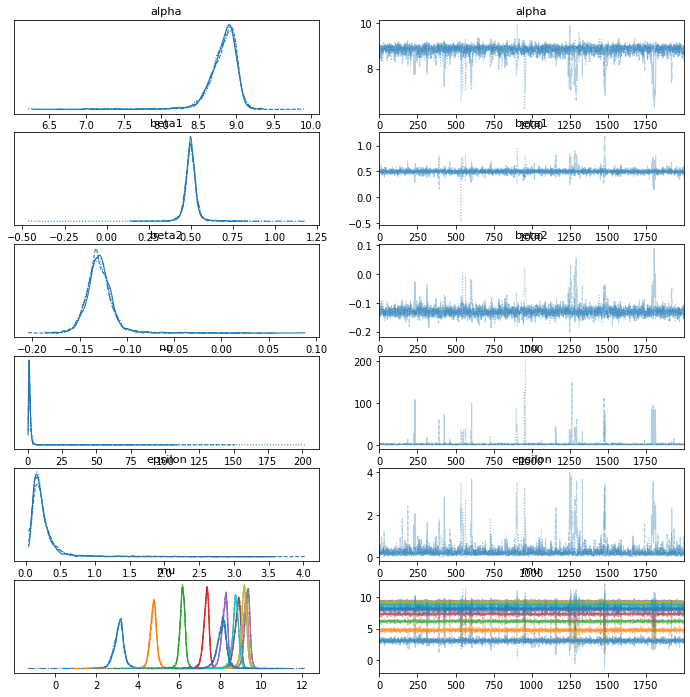

In [70]:
az.plot_trace(trace_poly_rob4)

<AxesSubplot:>

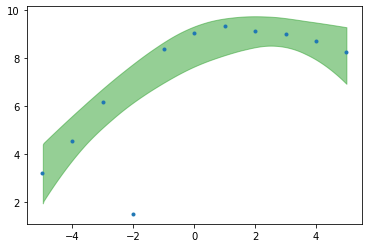

In [71]:
plt.plot(x,y,'C0.')
az.plot_hdi(x,trace_poly_rob4.posterior['mu'],color='C2',hdi_prob=.99)